# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of fresh vegetables crop production in Italy 2006-2022
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).


In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
fresh_veg = pd.read_csv('./Italy_crop_data/fresh_veg.csv',skipinitialspace=True)
fresh_veg.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,RADIINGRE,chicory and radicchio in greenhouses,2006,2006,300,e,estimate data
1,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,RADIINGRE,chicory and radicchio in greenhouses,2007,2007,450,NaN,NaN
2,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,RADIINGRE,chicory and radicchio in greenhouses,2008,2008,450,NaN,NaN
3,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,RADIINGRE,chicory and radicchio in greenhouses,2009,2009,375,e,estimate data
4,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,RADIINGRE,chicory and radicchio in greenhouses,2010,2010,425,e,estimate data


## Pre-processing dataset 

In [3]:
# Drop Columns
fresh_veg = fresh_veg.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
fresh_veg

,Territory,Data type,Type of crop,Select time,Value
0,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2006,300
1,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2007,450
2,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2008,450
3,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2009,375
4,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2010,425
...,...,...,...,...,...
158967,Rimini,harvested production - quintals,other fresh legumes,2022,1360
158968,Perugia,total area - hectares,other fresh legumes,2022,5
158969,Perugia,total production - quintals,other fresh legumes,2022,400
158970,Perugia,harvested production - quintals,other fresh legumes,2022,400


In [4]:
# Rename Columns
fresh_veg = fresh_veg.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(fresh_veg):
    print('DATASET SHAPE: ', fresh_veg.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(fresh_veg.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(fresh_veg.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(fresh_veg.isnull().sum())
show_info(fresh_veg)

DATASET SHAPE:  (158972, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158972 entries, 0 to 158971
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   City       158972 non-null  object
 1   Data_type  158972 non-null  object
 2   Type_crop  158972 non-null  object
 3   Year       158972 non-null  int64 
 4   Value      158972 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 6.1+ MB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City           110
Data_type        5
Type_crop       68
Year            17
Value        15938
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing fresh vegetables

In [6]:
#fresh_veg.City.unique()


In [6]:
fresh_veg.Data_type.unique()

array(['total production - quintals ', 'harvested production - quintals ',
       'total area - ares', 'total area - hectares',
       'production area - hectares '], dtype=object)

## Select only values for total fresh vegetables production - quintals


In [7]:
fresh_veg_prod = fresh_veg[fresh_veg['Data_type'] == 'total production - quintals ']
fresh_veg_prod.head()

,City,Data_type,Type_crop,Year,Value
0,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2006,300
1,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2007,450
2,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2008,450
3,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2009,375
4,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2010,425


In [8]:
fresh_veg_prod['Value'] = fresh_veg_prod['Value']/10
fresh_veg_prod

,City,Data_type,Type_crop,Year,Value
0,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2006,30.0
1,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2007,45.0
2,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2008,45.0
3,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2009,37.5
4,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2010,42.5
...,...,...,...,...,...
158950,Salerno,total production - quintals,tomato for process in greenhouse,2021,2500.0
158953,Lecce,total production - quintals,tomato for process in greenhouse,2021,2200.0
158963,Imperia,total production - quintals,other fresh legumes,2022,7.0
158966,Rimini,total production - quintals,other fresh legumes,2022,136.0


In [9]:
fresh_veg_prod = fresh_veg_prod.rename(columns = {'Value':'Total_production'})
fresh_veg_prod

,City,Data_type,Type_crop,Year,Total_production
0,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2006,30.0
1,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2007,45.0
2,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2008,45.0
3,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2009,37.5
4,Cuneo,total production - quintals,chicory and radicchio in greenhouses,2010,42.5
...,...,...,...,...,...
158950,Salerno,total production - quintals,tomato for process in greenhouse,2021,2500.0
158953,Lecce,total production - quintals,tomato for process in greenhouse,2021,2200.0
158963,Imperia,total production - quintals,other fresh legumes,2022,7.0
158966,Rimini,total production - quintals,other fresh legumes,2022,136.0


In [10]:
fresh_veg_prod = fresh_veg_prod.drop(columns =['Data_type'])
fresh_veg_prod

,City,Type_crop,Year,Total_production
0,Cuneo,chicory and radicchio in greenhouses,2006,30.0
1,Cuneo,chicory and radicchio in greenhouses,2007,45.0
2,Cuneo,chicory and radicchio in greenhouses,2008,45.0
3,Cuneo,chicory and radicchio in greenhouses,2009,37.5
4,Cuneo,chicory and radicchio in greenhouses,2010,42.5
...,...,...,...,...
158950,Salerno,tomato for process in greenhouse,2021,2500.0
158953,Lecce,tomato for process in greenhouse,2021,2200.0
158963,Imperia,other fresh legumes,2022,7.0
158966,Rimini,other fresh legumes,2022,136.0


## Fresh vegetables production in 2006-2022

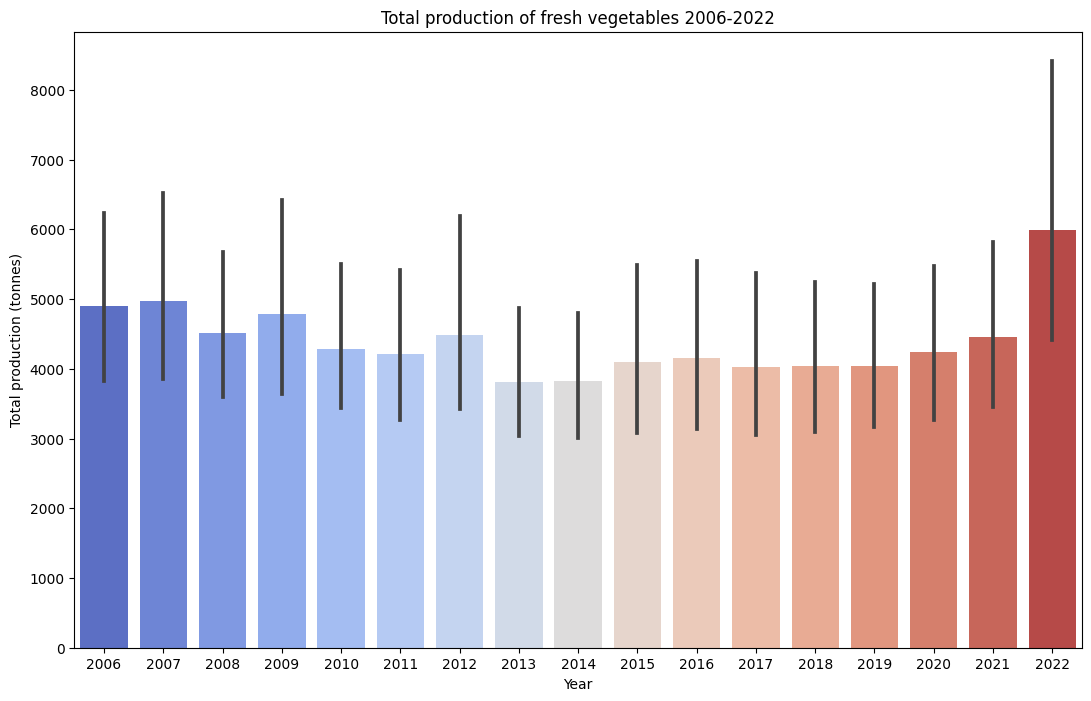

In [110]:
plt.figure(figsize= (13, 8))
sns.barplot(x= 'Year', y= 'Total_production',data = fresh_veg_prod, palette='coolwarm')
plt.title('Total production of fresh vegetables 2006-2022')
plt.xlabel('Year')
plt.ylabel('Total production (tonnes)')
plt.show()



## Fresh vegetables production by Cities 

In [13]:
fresh_veg_prod_region = fresh_veg_prod.groupby(by = fresh_veg_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False)
fresh_veg_prod_region



,City,Total_production
33,Foggia,34100942.8
71,Piacenza,12914999.6
85,Salerno,11736658.0
31,Ferrara,11375362.9
43,Latina,10778784.4
...,...,...
102,Varese,8159.2
24,Como,2599.0
90,Sondrio,1805.4
101,Valle d'Aosta / Vallée d'Aoste,883.2


In [14]:
region = fresh_veg_prod_region.nlargest(30, 'Total_production')

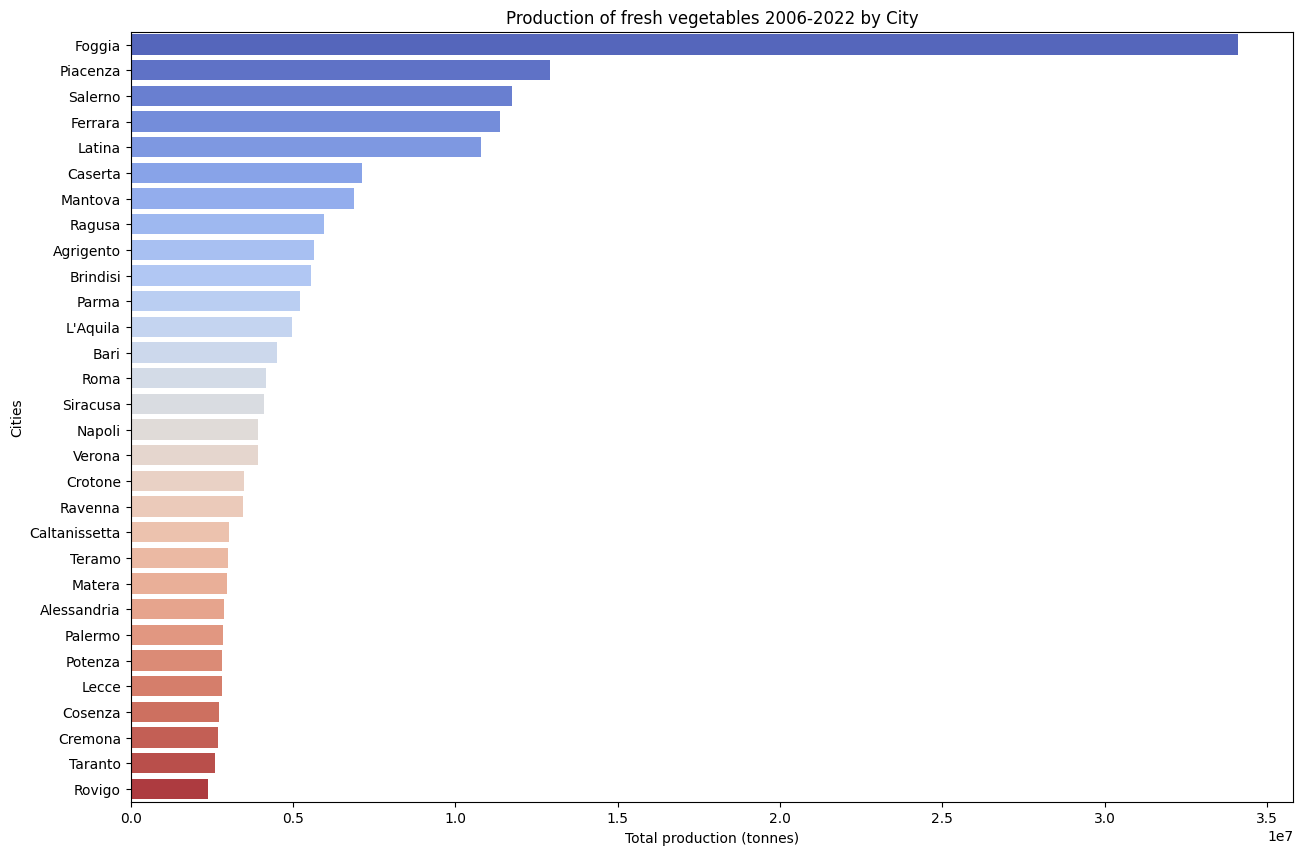

In [15]:
plt.figure(figsize= (15, 10))
sns.barplot(x= region['Total_production'],y= region['City'], orient='h', palette='coolwarm');
plt.title('Production of fresh vegetables 2006-2022 by City')
plt.xlabel('Total production (tonnes)')
plt.ylabel('Cities')
plt.show() 

## Fresh vegetables  2006-2022

In [16]:
print(fresh_veg_prod.Type_crop.max())
print(fresh_veg_prod.Type_crop.value_counts())
print(fresh_veg_prod.Type_crop.nunique())



white cabbage
courgette in open field                                        1667
lettuce in open field                                          1598
fresh beans in open field                                      1547
cauliflower and broccoli in open field                         1537
onions in open field                                           1486
                                                               ... 
red cabbage                                                      25
shallots in open field                                           20
other leafy or stalked vegetables n.e.c. (excluding chards)       6
other fresh vegetables n.e.c. (excluding broad beans)             5
tomato for process in greenhouse                                  3
Name: Type_crop, Length: 68, dtype: int64
68


Dataset shows there are 68 different types of industrial crop cultivated in Italy. The top most produced crops are :
Courgette in open field, Fresh beans in open field, Lettuce in open field, Onions in open field, Cauliflower and Broccoli in open field. 


In [17]:
# rename 

fresh_veg_prod = fresh_veg_prod.replace('courgette in open field','courgette-field')
fresh_veg_prod = fresh_veg_prod.replace('fresh beans in open field','fresh-beans-field')
fresh_veg_prod = fresh_veg_prod.replace('lettuce in open field','lettuce-field')                                            
fresh_veg_prod = fresh_veg_prod.replace('onions in open field','onions-field')
fresh_veg_prod = fresh_veg_prod.replace('tomato for fresh consumption','fresh-tomato')
fresh_veg_prod = fresh_veg_prod.replace('melon in open field','melon-field')
fresh_veg_prod = fresh_veg_prod.replace('egg-plant in open field','egg-plant-field')
fresh_veg_prod = fresh_veg_prod.replace('chicory in open field','chicory-field')
fresh_veg_prod = fresh_veg_prod.replace('red pepper in open field','red-pepper-field')
fresh_veg_prod = fresh_veg_prod.replace('cauliflower and broccoli in open field','cauliflower&broccoli-field')




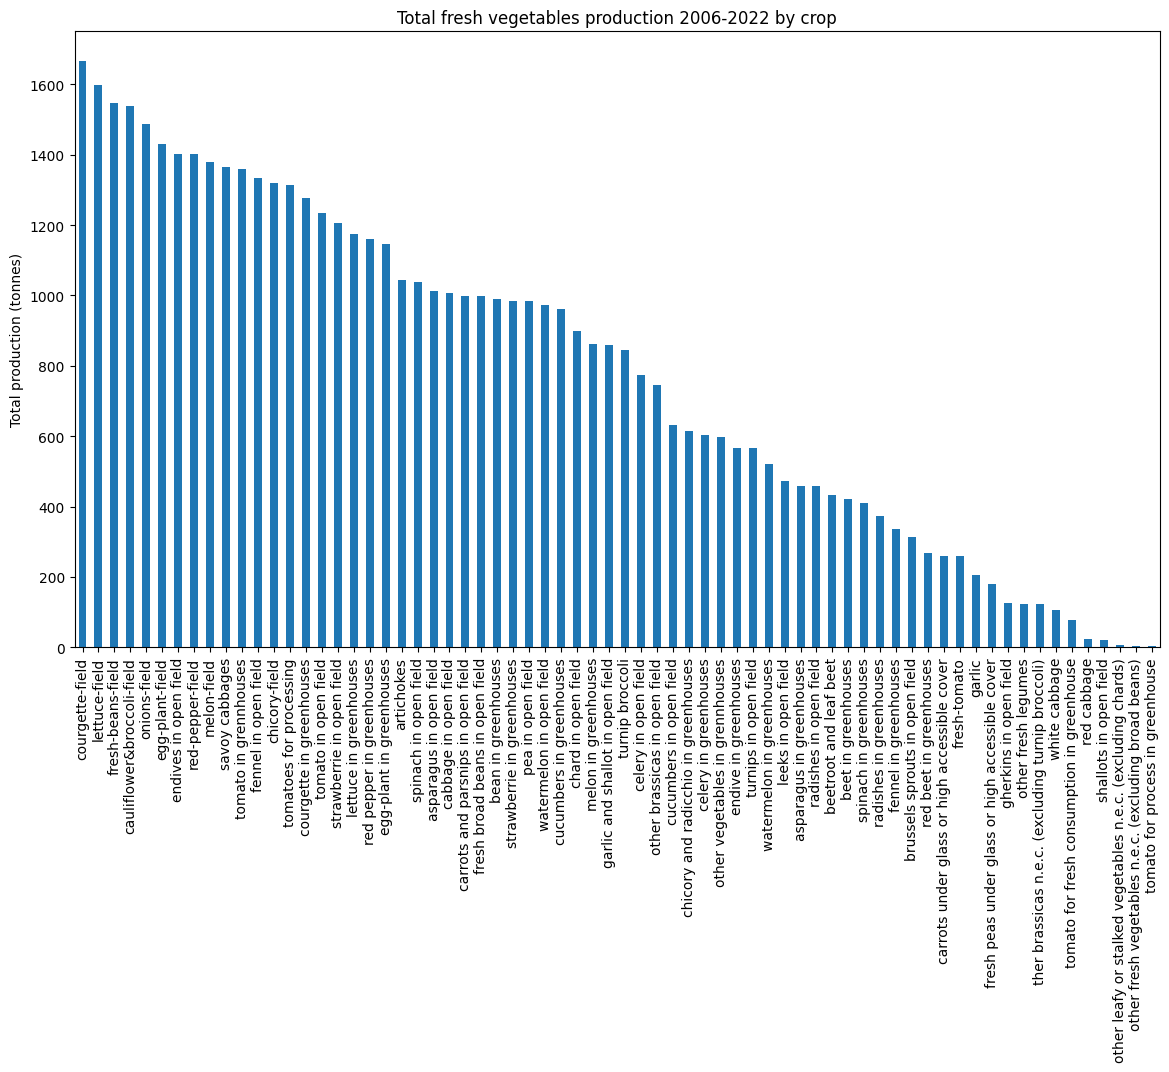

In [111]:
plt.figure(figsize=(14,8))
fresh_veg_prod ['Type_crop'].value_counts().plot.bar()
plt.title('Total fresh vegetables production 2006-2022 by crop')
plt.ylabel('Total production (tonnes)')
plt.show()


## Subseting data

In [24]:
fresh_veg_top10 = fresh_veg_prod.apply(lambda row: row[fresh_veg_prod['Type_crop'].isin(['courgette-field', 'fresh-beans-field',
                                                                                         'lettuce-field','onions-field',
                                                                                         'cauliflower&broccoli-field',
                                                                                        'fresh-tomato','melon-field','egg-plant-field',
                                                                                         'chicory-field','red-pepper-field'])])

fresh_veg_top10.head()

,City,Type_crop,Year,Total_production
19889,Torino,melon-field,2020,105.0
19890,Torino,melon-field,2021,132.0
19891,Torino,melon-field,2022,80.0
19897,Biella,melon-field,2020,8.0
19898,Biella,melon-field,2021,0.0


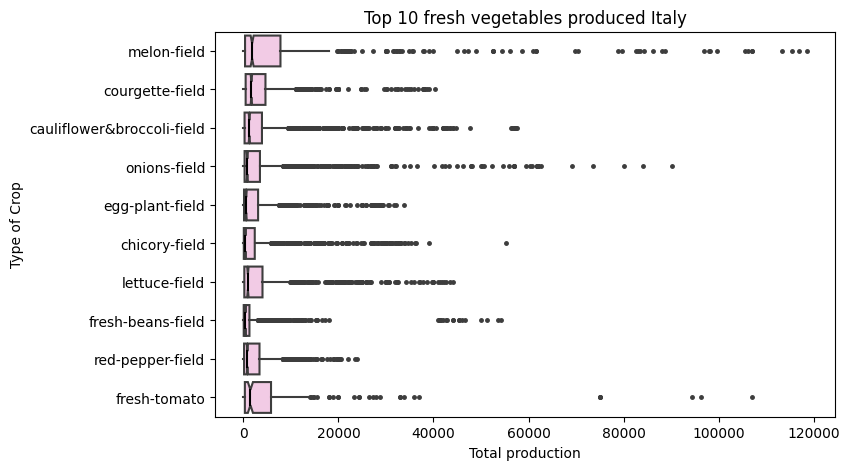

In [25]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=fresh_veg_top10, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)
plt.title('Top 10 fresh vegetables produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

## Vizualization of ten type of fresh vegetables produced in Italy in the period of 2006-2022 

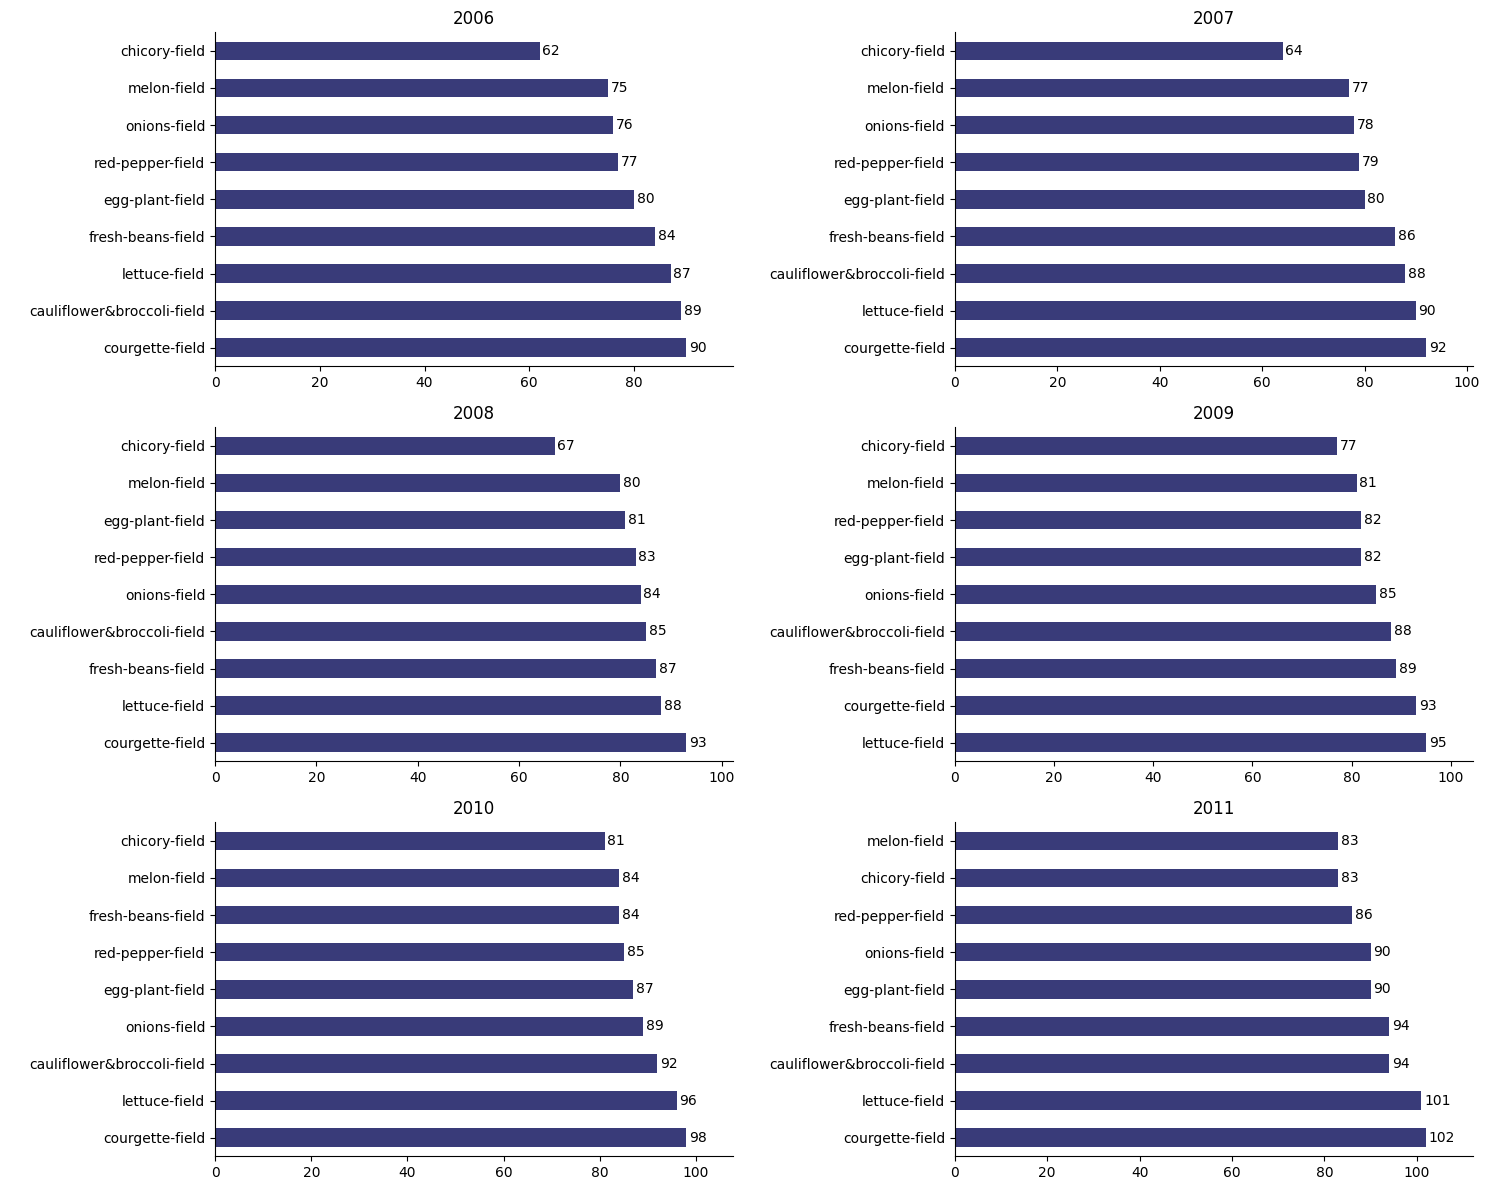

In [31]:
fig, axs = plt.subplots(3,2, figsize=(15 ,12))

plot1 = fresh_veg_top10[fresh_veg_top10.Year == 2006].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2006', ax=axs[0,0])
plot2 = fresh_veg_top10[fresh_veg_top10.Year == 2007].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2007', ax=axs[0,1])
plot3 = fresh_veg_top10[fresh_veg_top10.Year == 2008].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2008', ax=axs[1,0])
plot4 = fresh_veg_top10[fresh_veg_top10.Year == 2009].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2009', ax=axs[1,1])
plot5 = fresh_veg_top10[fresh_veg_top10.Year == 2010].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2010', ax=axs[2,0])
plot6 = fresh_veg_top10[fresh_veg_top10.Year == 2011].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2011', ax=axs[2,1])


for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
sns.despine()
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

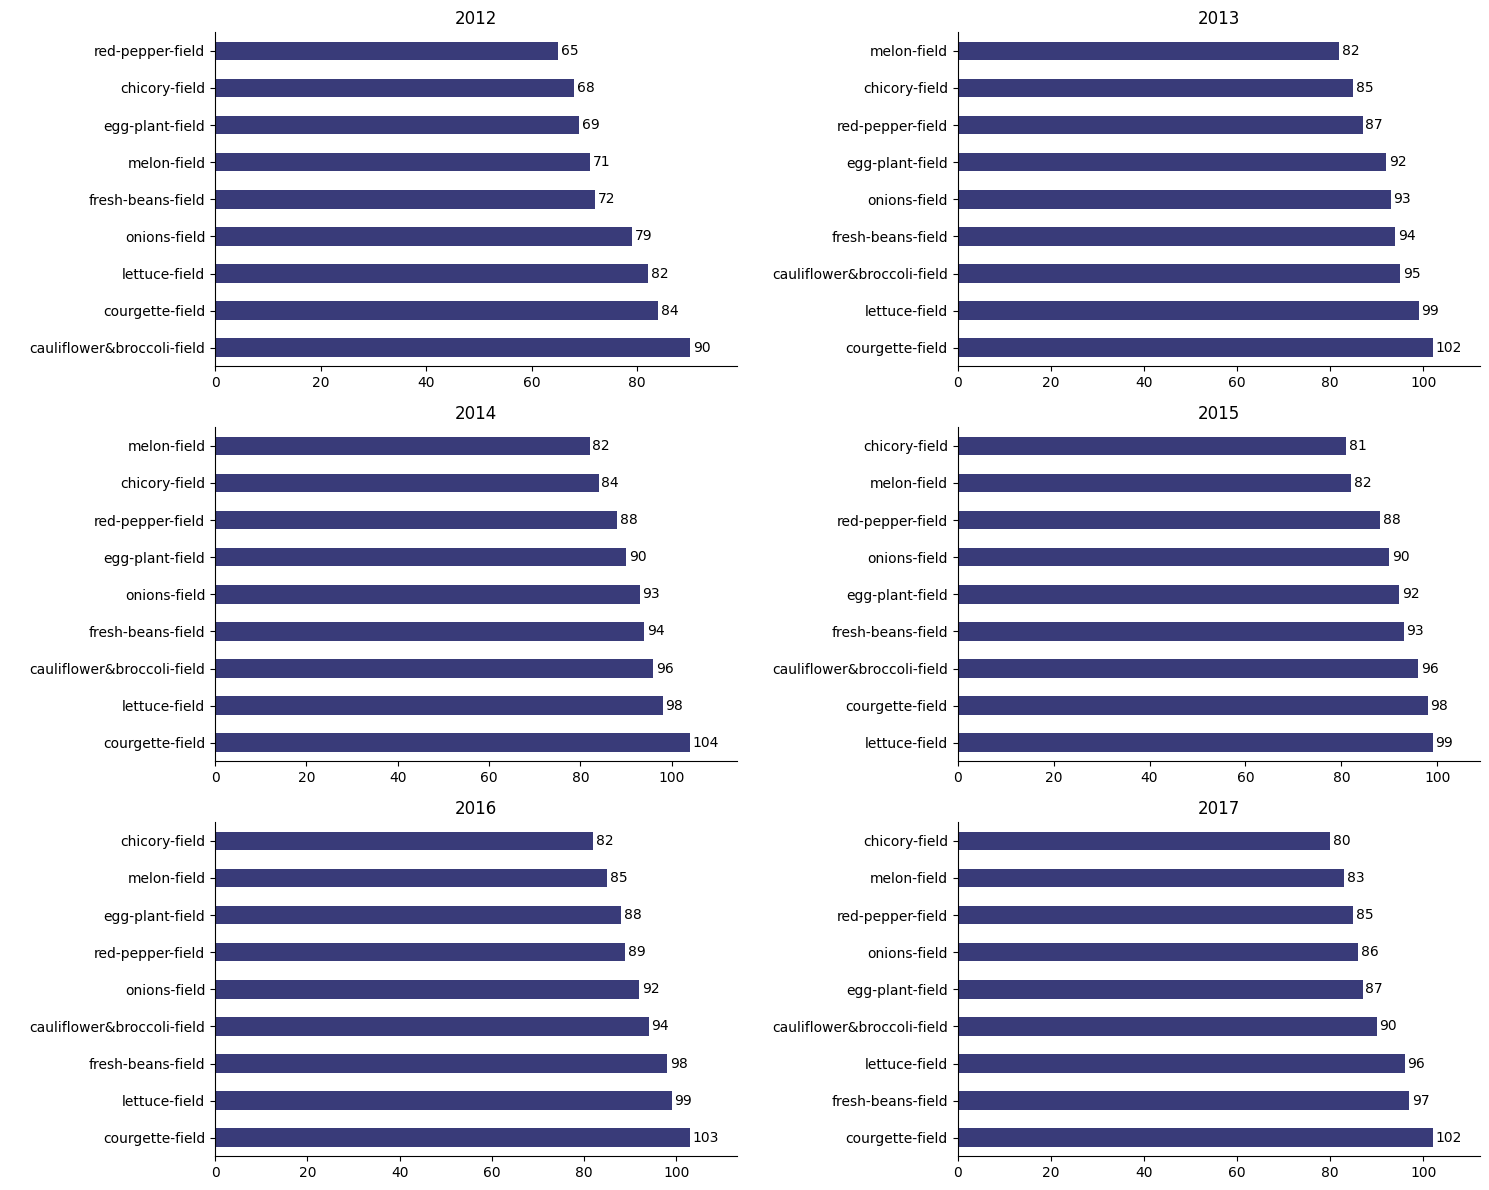

In [32]:
fig, axs = plt.subplots(3,2, figsize=(15, 12))

plot7 = fresh_veg_top10[fresh_veg_top10.Year == 2012].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2012', ax=axs[0,0])
plot8 = fresh_veg_top10[fresh_veg_top10.Year == 2013].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2013', ax=axs[0,1])
plot9 = fresh_veg_top10[fresh_veg_top10.Year == 2014].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2014', ax=axs[1,0])
plot10 = fresh_veg_top10[fresh_veg_top10.Year == 2015].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2015', ax=axs[1,1])
plot11 = fresh_veg_top10[fresh_veg_top10.Year == 2016].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2016', ax=axs[2,0])
plot12 = fresh_veg_top10[fresh_veg_top10.Year == 2017].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2017', ax=axs[2,1])


for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')                                                                                                 
sns.despine()
plt.tight_layout()
plt.show

IndexError: list index out of range

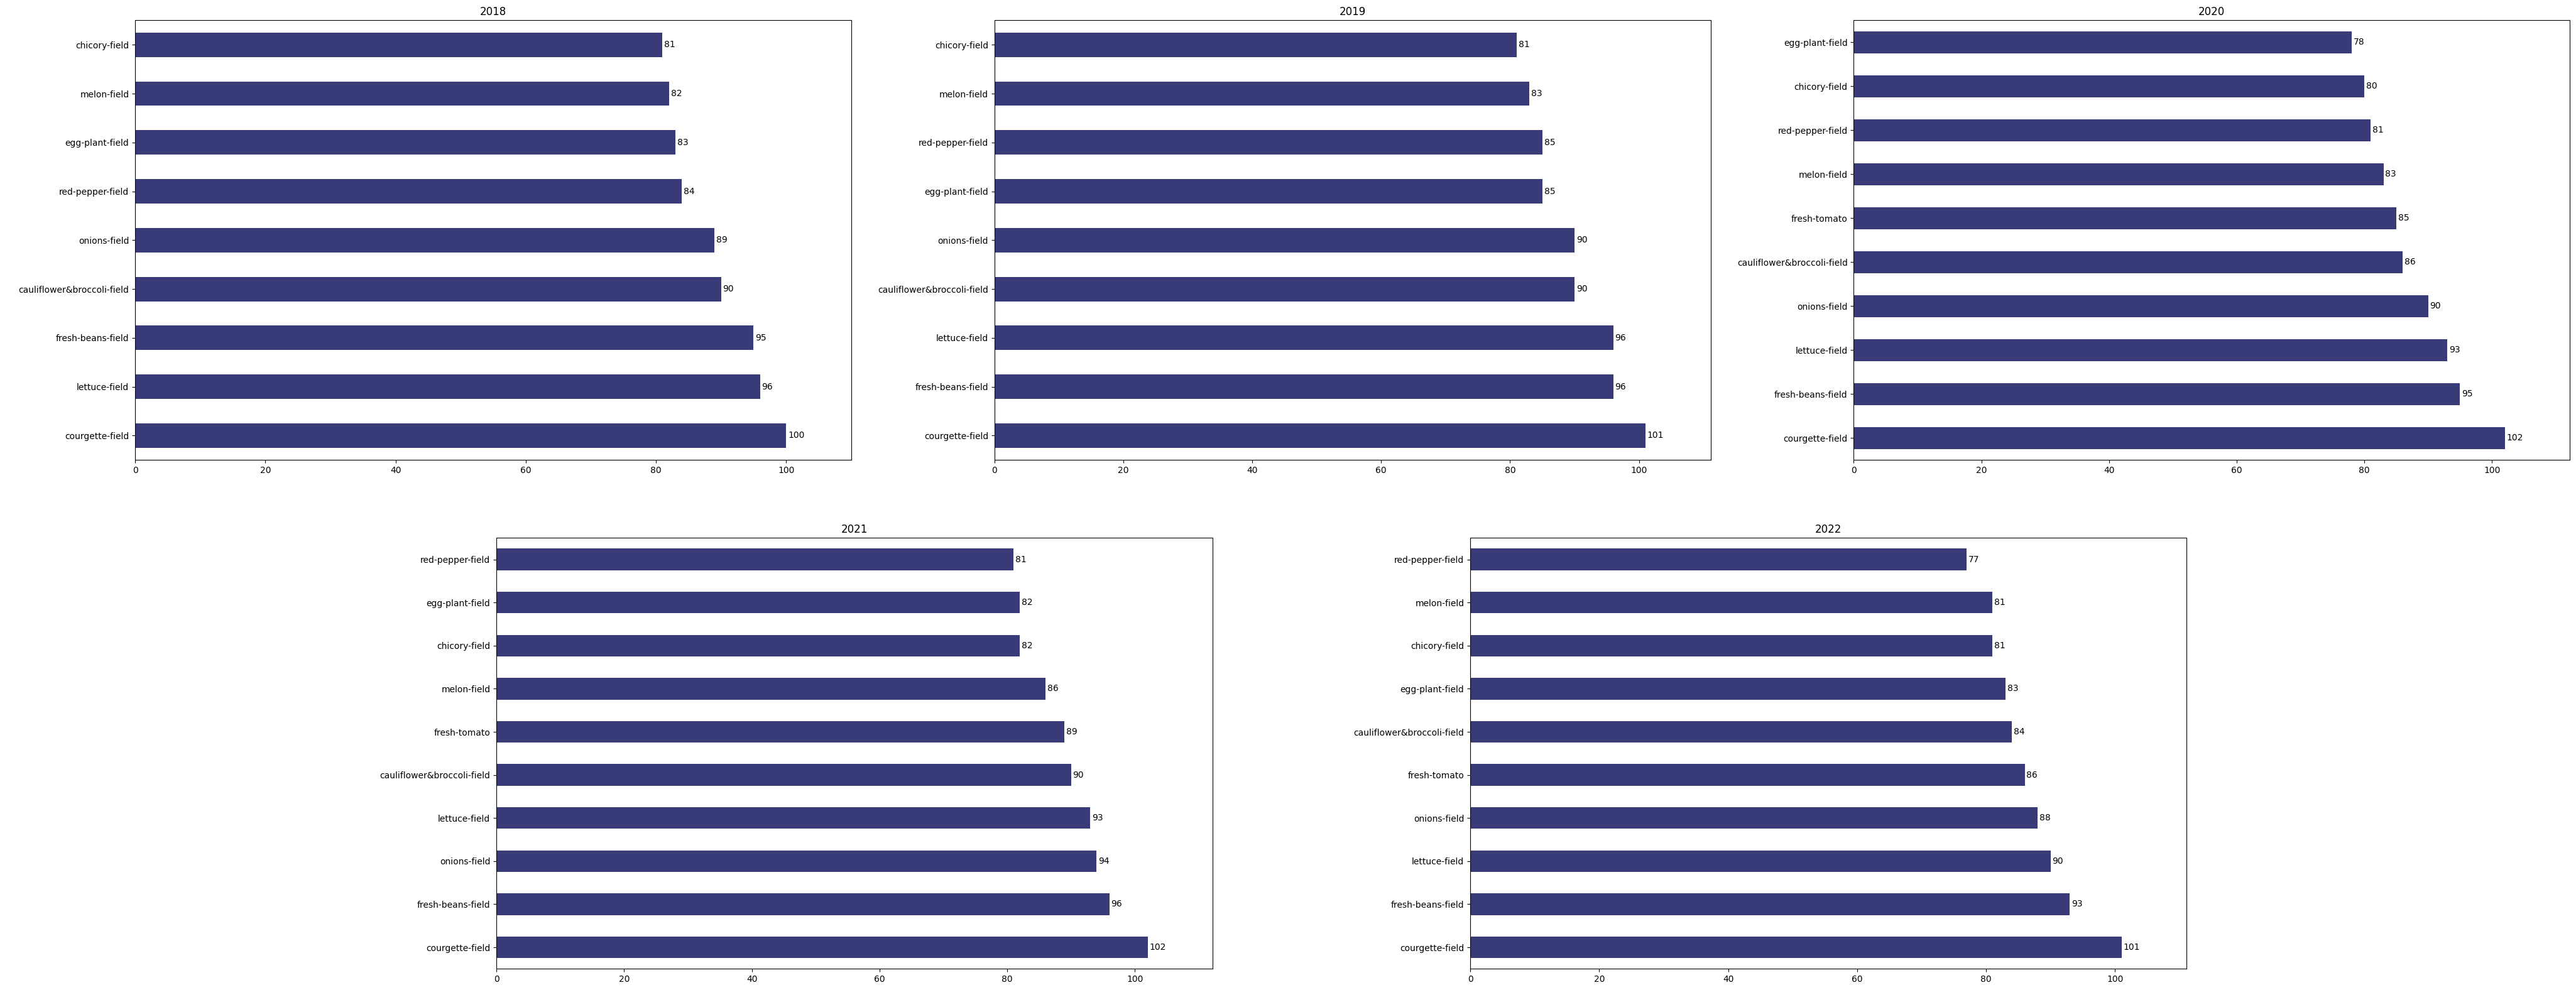

In [51]:
fig, axs = plt.subplots(2,3, figsize=(50,20))

axs[1,0].set_position([0.24,0.125,0.228,0.343])
axs[1,1].set_position([0.55,0.125,0.228,0.343])
axs[1,2].set_visible(False)


plot13 = fresh_veg_top10[fresh_veg_top10.Year == 2018].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2018', ax=axs[0,0])
plot14 = fresh_veg_top10[fresh_veg_top10.Year == 2019].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2019', ax=axs[0,1])
plot15 = fresh_veg_top10[fresh_veg_top10.Year == 2020].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2020', ax=axs[0,2])
plot16 = fresh_veg_top10[fresh_veg_top10.Year == 2021].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2021', ax=axs[1,0])
plot17 = fresh_veg_top10[fresh_veg_top10.Year == 2022].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2022', ax=axs[1,1])


for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')                                                                                                 
sns.despine()
plt.tight_layout()
plt.show

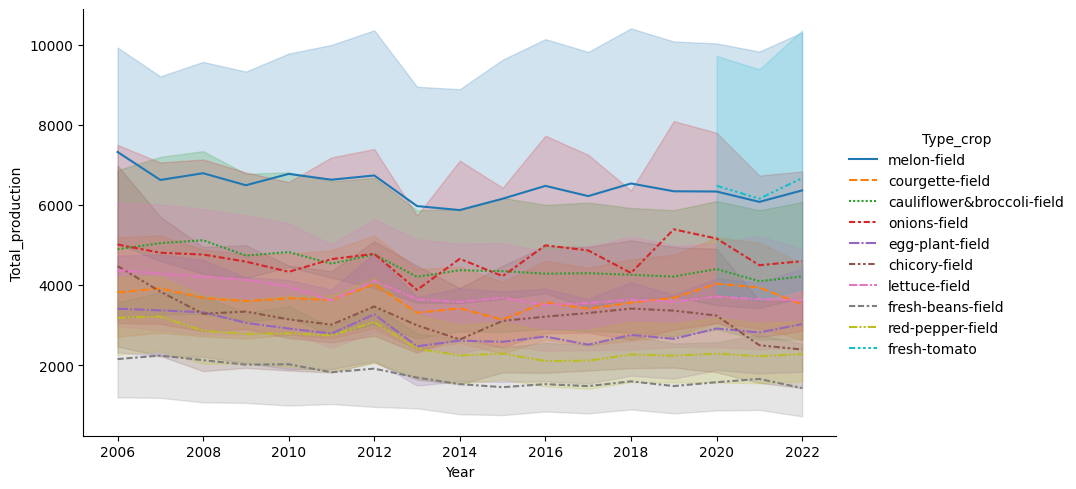

In [52]:
#Crop harvested by year
plotcrop10 = sns.relplot(kind='line', data=fresh_veg_top10, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


The relplot shows the mean and 95% CI for each crop.


### Create columns for each type crop

In [53]:
# Create columns for each type crop
fresh_veg_top10_pivot = fresh_veg_top10.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
fresh_veg_top10_pivot

Total_production                                \
Type_crop      cauliflower&broccoli-field chicory-field courgette-field   
City      Year                                                            
Agrigento 2006                     6708.0           NaN          2200.0   
          2007                     7040.0           NaN          2665.0   
          2008                     7460.0           NaN          2898.0   
          2009                     8093.0           NaN          2685.0   
          2010                     8810.0           NaN          2873.0   
...                                   ...           ...             ...   
Viterbo   2018                     1250.0           NaN          1400.0   
          2019                     1145.0           NaN          1310.0   
          2020                     1185.0           NaN          1422.0   
          2021                     2280.0           NaN          1420.0   
          2022                     2260.0          48.0          1390.0   

                                                                             \
Type_crop      egg-plant-field fresh-beans-field fresh-tomato lettuce-field   
City      Year                                                                
Agrigento 2006          4329.0             368.0          NaN        3900.0   
          2007          4560.0             378.0          NaN        4030.0   
          2008          4875.0             389.5          NaN        4620.0   
          2009          6243.0             560.0          NaN        5810.0   
          2010          6865.0             560.0          NaN        5523.0   
...                        ...               ...          ...           ...   
Viterbo   2018           144.0             580.0          NaN          40.0   
          2019           144.0             560.0          NaN          32.5   
          2020           159.0             554.0       3190.0          32.0   
          2021           159.0             552.0       2980.0          41.0   
          2022           158.0             552.0       2950.0          32.0   

                                                          
Type_crop      melon-field onions-field red-pepper-field  
City      Year                                            
Agrigento 2006     70400.0       4845.0           3060.0  
          2007     46420.0       5184.0           3268.0  
          2008     69680.0       5871.0           3675.0  
          2009     82659.0       9170.0           4723.0  
          2010     86251.0       9821.0           4911.0  
...                    ...          ...              ...  
Viterbo   2018      9450.0        310.0            570.0  
          2019      8000.0        287.0            570.0  
          2020      8200.0        288.0            560.0  
          2021      8100.0        208.5            550.0  
          2022      8040.0        208.0            540.0  

[1767 rows x 10 columns]

In [54]:
# Drop level
fresh_veg_top10_pivot.columns = fresh_veg_top10_pivot.columns.droplevel()
fresh_veg_top10_pivot

Type_crop       cauliflower&broccoli-field  chicory-field  courgette-field  \
City      Year                                                               
Agrigento 2006                      6708.0            NaN           2200.0   
          2007                      7040.0            NaN           2665.0   
          2008                      7460.0            NaN           2898.0   
          2009                      8093.0            NaN           2685.0   
          2010                      8810.0            NaN           2873.0   
...                                    ...            ...              ...   
Viterbo   2018                      1250.0            NaN           1400.0   
          2019                      1145.0            NaN           1310.0   
          2020                      1185.0            NaN           1422.0   
          2021                      2280.0            NaN           1420.0   
          2022                      2260.0           48.0           1390.0   

Type_crop       egg-plant-field  fresh-beans-field  fresh-tomato  \
City      Year                                                     
Agrigento 2006           4329.0              368.0           NaN   
          2007           4560.0              378.0           NaN   
          2008           4875.0              389.5           NaN   
          2009           6243.0              560.0           NaN   
          2010           6865.0              560.0           NaN   
...                         ...                ...           ...   
Viterbo   2018            144.0              580.0           NaN   
          2019            144.0              560.0           NaN   
          2020            159.0              554.0        3190.0   
          2021            159.0              552.0        2980.0   
          2022            158.0              552.0        2950.0   

Type_crop       lettuce-field  melon-field  onions-field  red-pepper-field  
City      Year                                                              
Agrigento 2006         3900.0      70400.0        4845.0            3060.0  
          2007         4030.0      46420.0        5184.0            3268.0  
          2008         4620.0      69680.0        5871.0            3675.0  
          2009         5810.0      82659.0        9170.0            4723.0  
          2010         5523.0      86251.0        9821.0            4911.0  
...                       ...          ...           ...               ...  
Viterbo   2018           40.0       9450.0         310.0             570.0  
          2019           32.5       8000.0         287.0             570.0  
          2020           32.0       8200.0         288.0             560.0  
          2021           41.0       8100.0         208.5             550.0  
          2022           32.0       8040.0         208.0             540.0  

[1767 rows x 10 columns]

In [55]:
fresh_veg_top10_pivot = fresh_veg_top10_pivot.fillna(0)
fresh_veg_top10_pivot

Type_crop       cauliflower&broccoli-field  chicory-field  courgette-field  \
City      Year                                                               
Agrigento 2006                      6708.0            0.0           2200.0   
          2007                      7040.0            0.0           2665.0   
          2008                      7460.0            0.0           2898.0   
          2009                      8093.0            0.0           2685.0   
          2010                      8810.0            0.0           2873.0   
...                                    ...            ...              ...   
Viterbo   2018                      1250.0            0.0           1400.0   
          2019                      1145.0            0.0           1310.0   
          2020                      1185.0            0.0           1422.0   
          2021                      2280.0            0.0           1420.0   
          2022                      2260.0           48.0           1390.0   

Type_crop       egg-plant-field  fresh-beans-field  fresh-tomato  \
City      Year                                                     
Agrigento 2006           4329.0              368.0           0.0   
          2007           4560.0              378.0           0.0   
          2008           4875.0              389.5           0.0   
          2009           6243.0              560.0           0.0   
          2010           6865.0              560.0           0.0   
...                         ...                ...           ...   
Viterbo   2018            144.0              580.0           0.0   
          2019            144.0              560.0           0.0   
          2020            159.0              554.0        3190.0   
          2021            159.0              552.0        2980.0   
          2022            158.0              552.0        2950.0   

Type_crop       lettuce-field  melon-field  onions-field  red-pepper-field  
City      Year                                                              
Agrigento 2006         3900.0      70400.0        4845.0            3060.0  
          2007         4030.0      46420.0        5184.0            3268.0  
          2008         4620.0      69680.0        5871.0            3675.0  
          2009         5810.0      82659.0        9170.0            4723.0  
          2010         5523.0      86251.0        9821.0            4911.0  
...                       ...          ...           ...               ...  
Viterbo   2018           40.0       9450.0         310.0             570.0  
          2019           32.5       8000.0         287.0             570.0  
          2020           32.0       8200.0         288.0             560.0  
          2021           41.0       8100.0         208.5             550.0  
          2022           32.0       8040.0         208.0             540.0  

[1767 rows x 10 columns]

In [56]:
#Rename index
fresh_veg_top10_pivot = fresh_veg_top10_pivot.rename_axis(None,axis=1)
fresh_veg_top10_pivot

cauliflower&broccoli-field  chicory-field  courgette-field  \
City      Year                                                               
Agrigento 2006                      6708.0            0.0           2200.0   
          2007                      7040.0            0.0           2665.0   
          2008                      7460.0            0.0           2898.0   
          2009                      8093.0            0.0           2685.0   
          2010                      8810.0            0.0           2873.0   
...                                    ...            ...              ...   
Viterbo   2018                      1250.0            0.0           1400.0   
          2019                      1145.0            0.0           1310.0   
          2020                      1185.0            0.0           1422.0   
          2021                      2280.0            0.0           1420.0   
          2022                      2260.0           48.0           1390.0   

                egg-plant-field  fresh-beans-field  fresh-tomato  \
City      Year                                                     
Agrigento 2006           4329.0              368.0           0.0   
          2007           4560.0              378.0           0.0   
          2008           4875.0              389.5           0.0   
          2009           6243.0              560.0           0.0   
          2010           6865.0              560.0           0.0   
...                         ...                ...           ...   
Viterbo   2018            144.0              580.0           0.0   
          2019            144.0              560.0           0.0   
          2020            159.0              554.0        3190.0   
          2021            159.0              552.0        2980.0   
          2022            158.0              552.0        2950.0   

                lettuce-field  melon-field  onions-field  red-pepper-field  
City      Year                                                              
Agrigento 2006         3900.0      70400.0        4845.0            3060.0  
          2007         4030.0      46420.0        5184.0            3268.0  
          2008         4620.0      69680.0        5871.0            3675.0  
          2009         5810.0      82659.0        9170.0            4723.0  
          2010         5523.0      86251.0        9821.0            4911.0  
...                       ...          ...           ...               ...  
Viterbo   2018           40.0       9450.0         310.0             570.0  
          2019           32.5       8000.0         287.0             570.0  
          2020           32.0       8200.0         288.0             560.0  
          2021           41.0       8100.0         208.5             550.0  
          2022           32.0       8040.0         208.0             540.0  

[1767 rows x 10 columns]

In [57]:
# Reset index
fresh_veg_top10_pivot = fresh_veg_top10_pivot.reset_index()
fresh_veg_top10_pivot

,City,Year,cauliflower&broccoli-field,chicory-field,courgette-field,egg-plant-field,fresh-beans-field,fresh-tomato,lettuce-field,melon-field,onions-field,red-pepper-field
0,Agrigento,2006,6708.0,0.0,2200.0,4329.0,368.0,0.0,3900.0,70400.0,4845.0,3060.0
1,Agrigento,2007,7040.0,0.0,2665.0,4560.0,378.0,0.0,4030.0,46420.0,5184.0,3268.0
2,Agrigento,2008,7460.0,0.0,2898.0,4875.0,389.5,0.0,4620.0,69680.0,5871.0,3675.0
3,Agrigento,2009,8093.0,0.0,2685.0,6243.0,560.0,0.0,5810.0,82659.0,9170.0,4723.0
4,Agrigento,2010,8810.0,0.0,2873.0,6865.0,560.0,0.0,5523.0,86251.0,9821.0,4911.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1762,Viterbo,2018,1250.0,0.0,1400.0,144.0,580.0,0.0,40.0,9450.0,310.0,570.0
1763,Viterbo,2019,1145.0,0.0,1310.0,144.0,560.0,0.0,32.5,8000.0,287.0,570.0
1764,Viterbo,2020,1185.0,0.0,1422.0,159.0,554.0,3190.0,32.0,8200.0,288.0,560.0
1765,Viterbo,2021,2280.0,0.0,1420.0,159.0,552.0,2980.0,41.0,8100.0,208.5,550.0


## Estatistical analysis

In [58]:
fresh_veg_top10_pivot.describe()

,Year,cauliflower&broccoli-field,chicory-field,courgette-field,egg-plant-field,fresh-beans-field,fresh-tomato,lettuce-field,melon-field,onions-field,red-pepper-field
count,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000
mean,2014.046972,3914.507187,2376.624675,3427.074363,2326.653707,1516.131636,946.095982,3437.721958,5032.506112,3924.774533,1998.473231
std,4.861799,7981.360361,6020.491434,5264.257120,4961.054073,4864.697034,5988.134750,6611.308295,12607.003901,9788.684917,3503.889294
min,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,82.000000,0.000000,360.000000,50.000000,43.600000,0.000000,105.000000,30.000000,100.000000,23.000000
50%,2014.000000,735.000000,153.000000,1479.100000,337.400000,300.000000,0.000000,791.000000,870.000000,600.000000,389.400000
75%,2018.000000,3500.000000,1107.500000,4370.000000,2081.500000,1078.700000,0.000000,3421.250000,5500.000000,2700.000000,2316.000000
max,2022.000000,57467.600000,55211.400000,40400.000000,33740.000000,54240.500000,107050.000000,44000.000000,118560.000000,90200.000000,24000.000000


#### Data metrics : skew, kurtosis and mode



In [59]:
fresh_veg_top10_pivot_stats = fresh_veg_top10_pivot[['courgette-field', 'fresh-beans-field',
                                                      'lettuce-field','onions-field','cauliflower&broccoli-field',
                                                      'fresh-tomato','melon-field','egg-plant-field',
                                                      'chicory-field','red-pepper-field']]

print(fresh_veg_top10_pivot_stats.astype(float).skew())

print(fresh_veg_top10_pivot_stats.astype(float).kurtosis())

print(fresh_veg_top10_pivot_stats.astype(float).mode())



courgette-field                3.463877
fresh-beans-field              7.613004
lettuce-field                  3.273067
onions-field                   4.573826
cauliflower&broccoli-field     3.486411
fresh-tomato                  11.809365
melon-field                    5.654280
egg-plant-field                3.526248
chicory-field                  3.794932
red-pepper-field               2.796546
dtype: float64
courgette-field                16.270307
fresh-beans-field              66.027506
lettuce-field                  12.077926
onions-field                   24.361489
cauliflower&broccoli-field     14.155985
fresh-tomato                  167.440406
melon-field                    37.805042
egg-plant-field                13.937238
chicory-field                  15.799570
red-pepper-field                9.368485
dtype: float64
   courgette-field  fresh-beans-field  lettuce-field  onions-field  \
0              0.0                0.0            0.0           0.0   

   cauliflower&broc

### Calculate and print the interquartile range

In [60]:

Q1 = fresh_veg_top10_pivot_stats.quantile(0.25)
Q3 = fresh_veg_top10_pivot_stats.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


courgette-field               4010.00
fresh-beans-field             1035.10
lettuce-field                 3316.25
onions-field                  2600.00
cauliflower&broccoli-field    3418.00
fresh-tomato                     0.00
melon-field                   5470.00
egg-plant-field               2031.50
chicory-field                 1107.50
red-pepper-field              2293.00
dtype: float64


### Remove outliers and plot graphs



In [61]:
# Remove outliers

fresh_veg_top10_pivot_stats[~((fresh_veg_top10_pivot < (Q1 - 1.5 * IQR)) | (fresh_veg_top10_pivot_stats > (Q3 + 1.5 * IQR))).any(axis=1)]

print(fresh_veg_top10_pivot.shape)

(1767, 12)


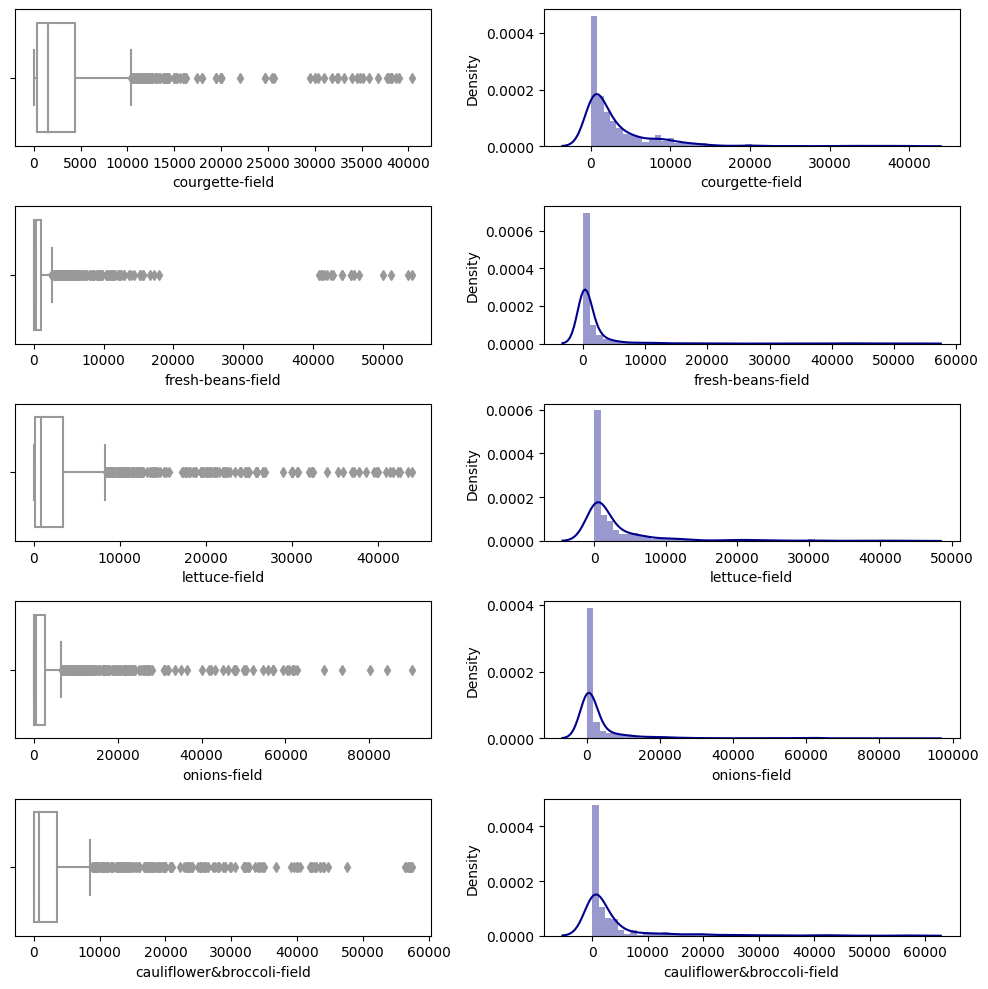

In [62]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= fresh_veg_top10_pivot_stats["courgette-field"], color = 'white', ax = ax[0,0])
sns.distplot(fresh_veg_top10_pivot_stats['courgette-field'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= fresh_veg_top10_pivot_stats["fresh-beans-field"],color = 'white', ax = ax[1,0])
sns.distplot(fresh_veg_top10_pivot_stats['fresh-beans-field'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= fresh_veg_top10_pivot_stats["lettuce-field"],color = 'white', ax = ax[2,0])
sns.distplot(fresh_veg_top10_pivot_stats['lettuce-field'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= fresh_veg_top10_pivot_stats["onions-field"], color = 'white', ax = ax[3,0])
sns.distplot(fresh_veg_top10_pivot_stats['onions-field'], color = 'darkblue', ax = ax[3,1])
sns.boxplot(x= fresh_veg_top10_pivot_stats["cauliflower&broccoli-field"], color = 'white',ax = ax[4,0])
sns.distplot(fresh_veg_top10_pivot_stats['cauliflower&broccoli-field'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

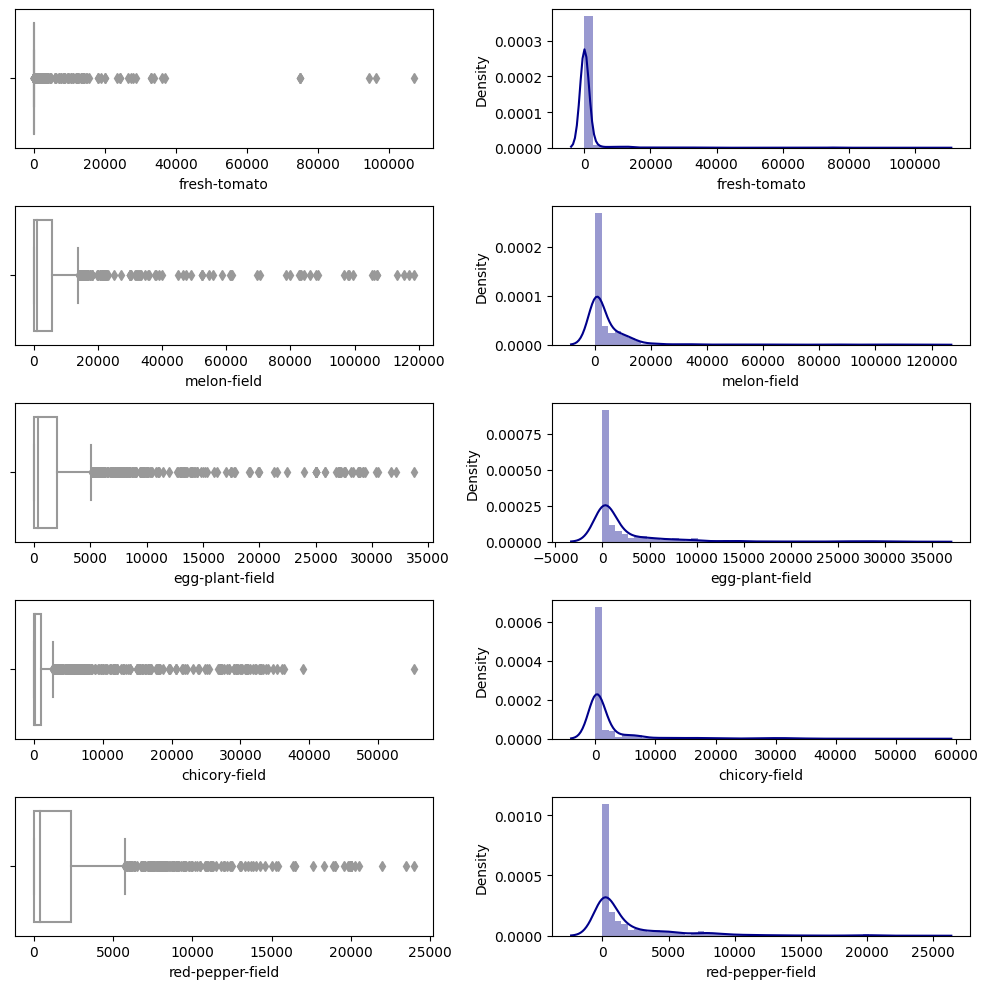

In [63]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= fresh_veg_top10_pivot_stats["fresh-tomato"], color = 'white', ax = ax[0,0])
sns.distplot(fresh_veg_top10_pivot_stats['fresh-tomato'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= fresh_veg_top10_pivot_stats["melon-field"],color = 'white', ax = ax[1,0])
sns.distplot(fresh_veg_top10_pivot_stats['melon-field'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= fresh_veg_top10_pivot_stats["egg-plant-field"],color = 'white', ax = ax[2,0])
sns.distplot(fresh_veg_top10_pivot_stats['egg-plant-field'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= fresh_veg_top10_pivot_stats["chicory-field"], color = 'white',ax = ax[3,0])
sns.distplot(fresh_veg_top10_pivot_stats['chicory-field'], color = 'darkblue',ax = ax[3,1])
sns.boxplot(x= fresh_veg_top10_pivot_stats["red-pepper-field"], color = 'white',ax = ax[4,0])
sns.distplot(fresh_veg_top10_pivot_stats['red-pepper-field'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

In [64]:
fresh_veg_top10_pivot

,City,Year,cauliflower&broccoli-field,chicory-field,courgette-field,egg-plant-field,fresh-beans-field,fresh-tomato,lettuce-field,melon-field,onions-field,red-pepper-field
0,Agrigento,2006,6708.0,0.0,2200.0,4329.0,368.0,0.0,3900.0,70400.0,4845.0,3060.0
1,Agrigento,2007,7040.0,0.0,2665.0,4560.0,378.0,0.0,4030.0,46420.0,5184.0,3268.0
2,Agrigento,2008,7460.0,0.0,2898.0,4875.0,389.5,0.0,4620.0,69680.0,5871.0,3675.0
3,Agrigento,2009,8093.0,0.0,2685.0,6243.0,560.0,0.0,5810.0,82659.0,9170.0,4723.0
4,Agrigento,2010,8810.0,0.0,2873.0,6865.0,560.0,0.0,5523.0,86251.0,9821.0,4911.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1762,Viterbo,2018,1250.0,0.0,1400.0,144.0,580.0,0.0,40.0,9450.0,310.0,570.0
1763,Viterbo,2019,1145.0,0.0,1310.0,144.0,560.0,0.0,32.5,8000.0,287.0,570.0
1764,Viterbo,2020,1185.0,0.0,1422.0,159.0,554.0,3190.0,32.0,8200.0,288.0,560.0
1765,Viterbo,2021,2280.0,0.0,1420.0,159.0,552.0,2980.0,41.0,8100.0,208.5,550.0


### Pre-process fertilizers dataset 

In [84]:
fertilizer = pd.read_csv('fertilizer_by_prov.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2006,2006,1227,NaN,NaN
1,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2007,2007,1812,NaN,NaN
2,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2008,2008,5224,NaN,NaN
3,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2009,2009,2051,NaN,NaN
4,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2010,2010,54,NaN,NaN


In [85]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [67]:
#fertilizer.Territory.unique()

In [86]:
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [87]:
fertilizer.loc[fertilizer['Data_type'] == 'fertilizers distributed - quintals','Fertilizers_tonnes' ] = fertilizer['Fertilizers_tonnes'] / 10


In [88]:
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,122.7
1,Torino,calcium cyanamide,2007,181.2
2,Torino,calcium cyanamide,2008,522.4
3,Torino,calcium cyanamide,2009,205.1
4,Torino,calcium cyanamide,2010,5.4
...,...,...,...,...
68381,Sud Sardegna,specific action products -,2017,335.0
68382,Sud Sardegna,specific action products -,2018,137.0
68383,Sud Sardegna,specific action products -,2019,164.0
68384,Sud Sardegna,specific action products -,2020,135.0


## Select ferlizers

In [89]:
fertilizer.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrates ', 'ammonium sulphate', 'urea',
       'other fertilizers different from calcium cyanamide, nitrates, ammonium sulphate, urea',
       'simple superphosphate', 'triple superphosphate',
       'other fertilizers different from simple superphosphate and triple superphosphate',
       'sulphate', 'chloride ',
       'other fertilizers different from sulphate and chloride ',
       'two components - nitrogen-phosphorous',
       'two components - phosphorus-potassium',
       'two components - nitrogen-potassium',
       'three components - nitrogen-phosphorous-phosphorous',
       'containing only one secondary macronutrient - calcium oxide',
       'containing only one secondary macronutrient - magnesium oxide',
       'containing only one secondary macronutrient - sulphur oxide',
       'containing only one secondary macronutrient',
       'containing micronutrients containing only a micronutrient in mineral form',
       'containing micronutrients 

In [90]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())
print(fertilizer.Type_fertilizer.nunique())

vegetable soil amendment
specific action products -                                                               3497
three components - nitrogen-phosphorous-phosphorous                                      1941
containing only one secondary macronutrient - magnesium oxide                            1749
soil correctives - other  soil correctives                                               1749
other soil amendments                                                                    1749
peaty soil amendment                                                                     1749
mixed soil amendment                                                                     1749
vegetable soil amendment                                                                 1749
organic-mineral fertilizers - compound                                                   1749
organic-mineral fertilizers - straight nitrogen                                          1749
organic fertilizers - compound     

In [91]:
# Rename name of fertilizers 
fertilizer = fertilizer.replace('organic fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - compound','organic-mineral')
fertilizer = fertilizer.replace('organic fertilizers - compound','organic')
fertilizer = fertilizer.replace('mixed soil amendment','mix-amend')
fertilizer = fertilizer.replace('peaty soil amendment','peaty-amend')
fertilizer = fertilizer.replace('peaty amendment','peaty-amend')
fertilizer = fertilizer.replace('peat amendment','peaty-amend')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - nitrogen-potassium','nitrogen-potassium')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - phosphorus-potassium','phosphorus-potassium')
fertilizer = fertilizer.replace('vegetable soil amendment', 'organic')

In [92]:
fertilizer = fertilizer.apply(lambda row: row[fertilizer['Type_fertilizer'].isin(['calcium cyanamide ','nitrates','organic', 'urea','nitrogen-potassium',
                                                                                  'phosphorus-potassium','ammonium sulphate','calcium cyanamide', 
                                                                                  'nitrogen-phosphorous','peaty-amend','organic-nitrogen' ])])

fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,122.7
1,Torino,calcium cyanamide,2007,181.2
2,Torino,calcium cyanamide,2008,522.4
3,Torino,calcium cyanamide,2009,205.1
4,Torino,calcium cyanamide,2010,5.4


<AxesSubplot: >

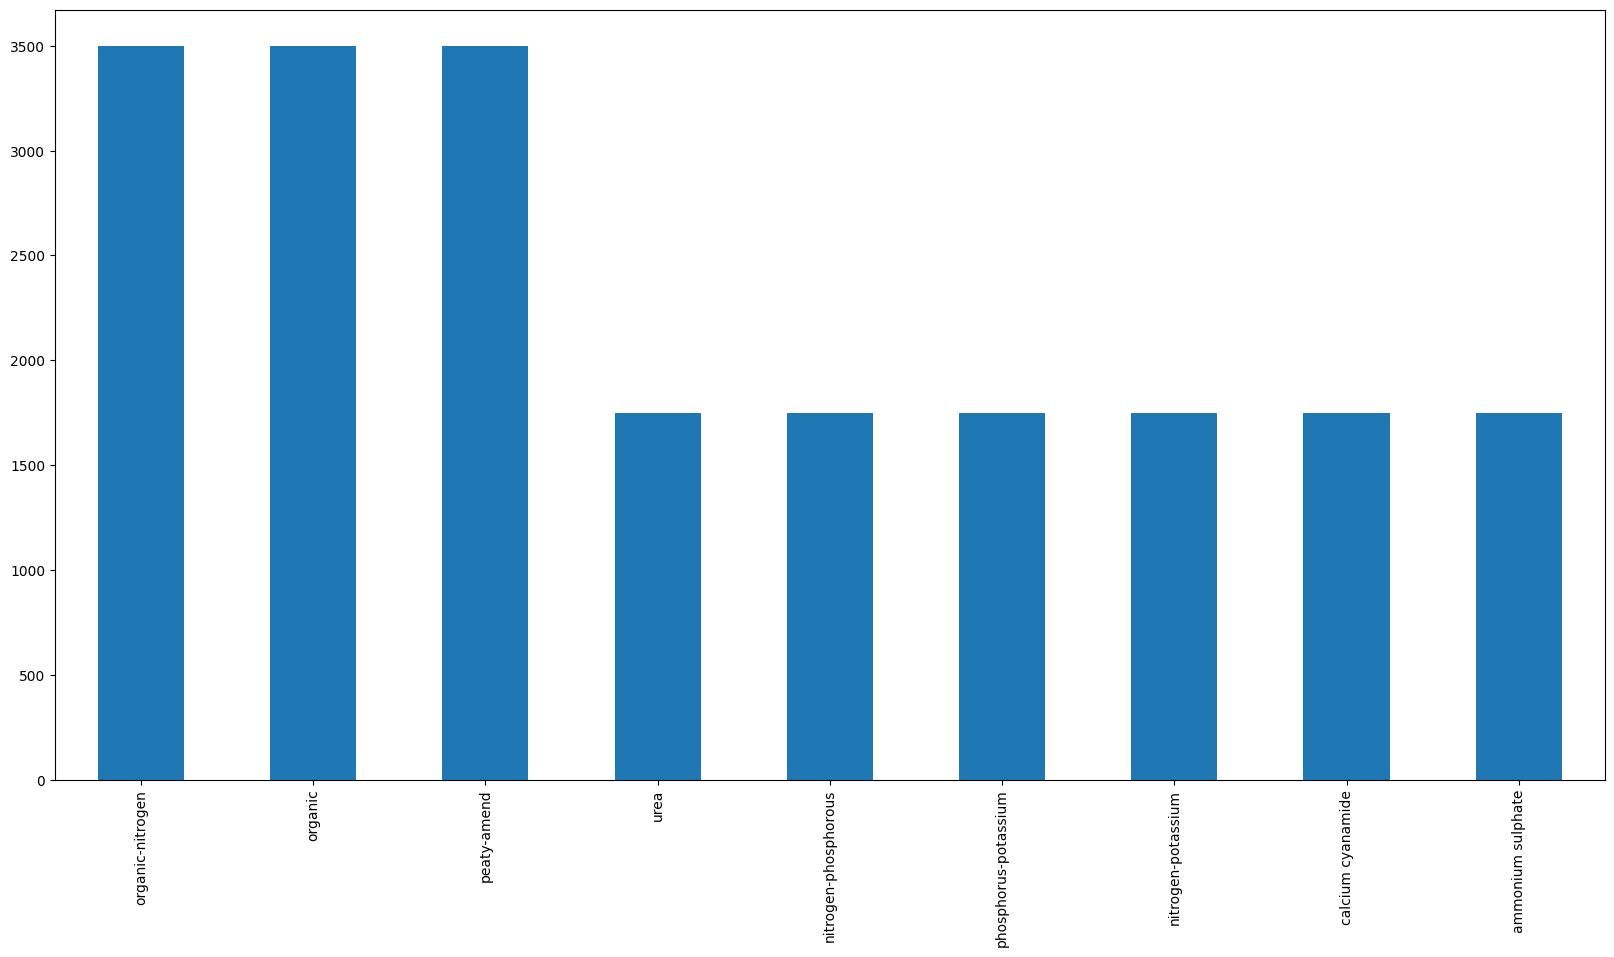

In [93]:
plt.figure(figsize=(20,10))
fertilizer['Type_fertilizer'].value_counts().plot.bar()

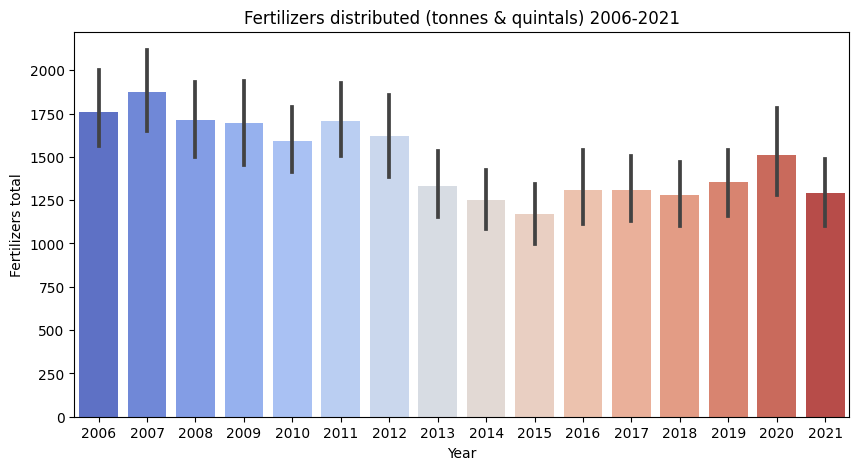

In [94]:
# fertilizer distributed tonnes and quintals
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Fertilizers_tonnes',data = fertilizer, palette='coolwarm')
plt.title('Fertilizers distributed (tonnes & quintals) 2006-2021')
plt.xlabel('Year')
plt.ylabel('Fertilizers total')
plt.show()


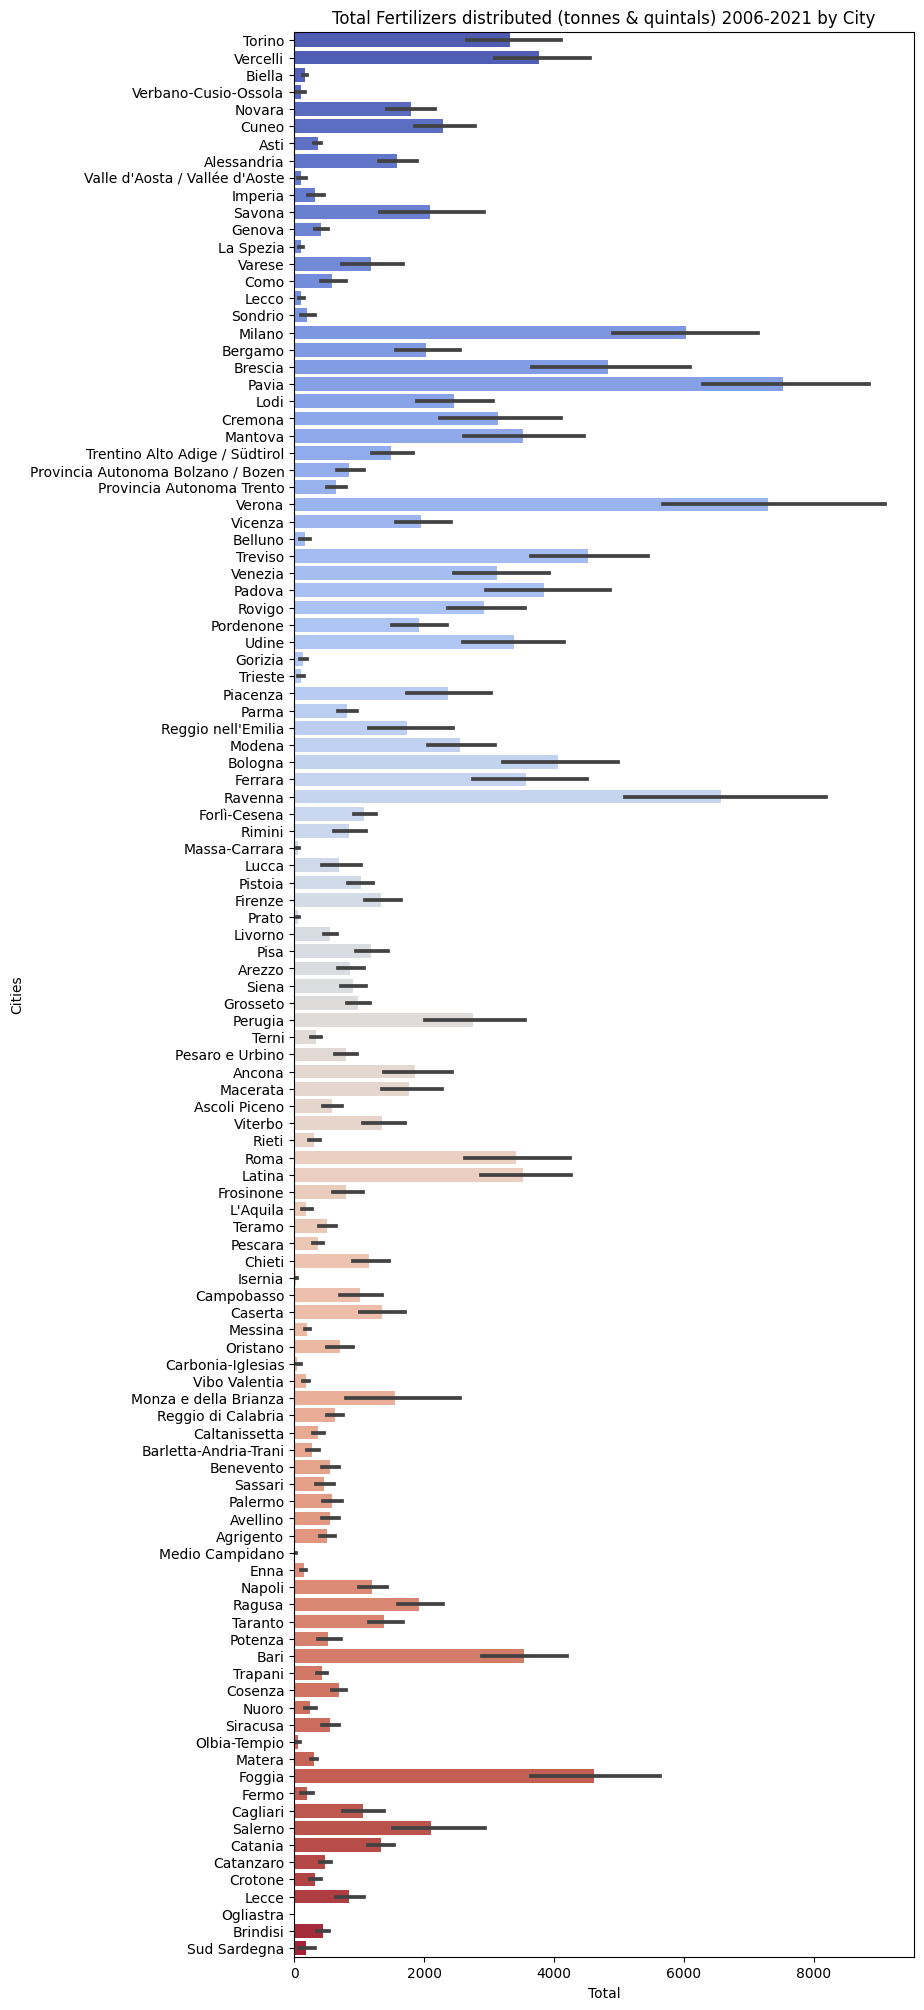

In [95]:
plt.figure(figsize= (8,25))
sns.barplot(x=fertilizer['Fertilizers_tonnes'],y= fertilizer['City'], orient='h', palette='coolwarm');
plt.title('Total Fertilizers distributed (tonnes & quintals) 2006-2021 by City')
plt.xlabel('Total')
plt.ylabel('Cities')
plt.show()

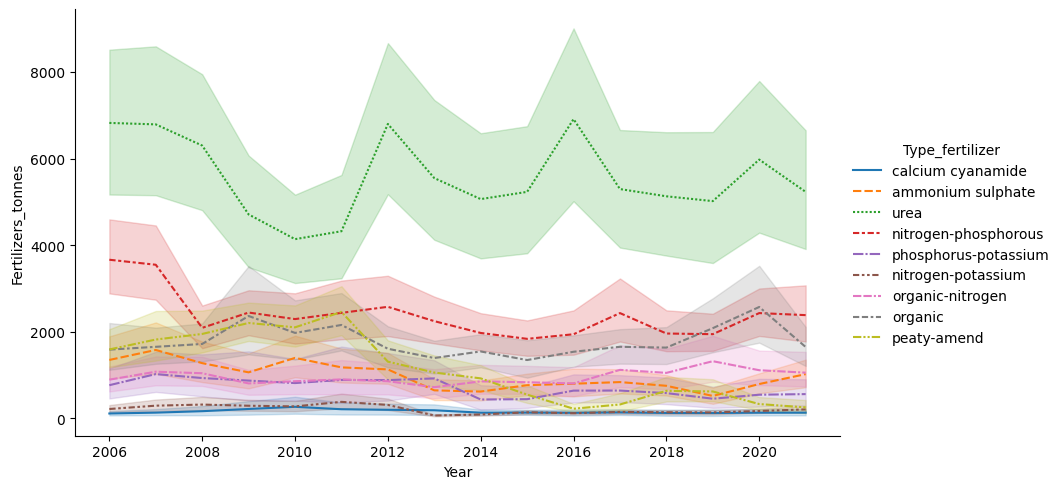

In [96]:
#Fertilizers distributed by year

fertilizer_plot = sns.relplot(kind='line', data=fertilizer, x='Year', y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)


In [97]:
# Create columns for each type of fertilizer 
fertilizer_pivot = fertilizer.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer_pivot

Fertilizers_tonnes                                         \
Type_fertilizer  ammonium sulphate calcium cyanamide nitrogen-phosphorous   
City      Year                                                              
Agrigento 2006               168.7               0.0                497.7   
          2007               217.1               0.0                649.8   
          2008               140.0               0.0                521.3   
          2009               140.4               0.0                380.8   
          2010               141.6              14.0                327.1   
...                            ...               ...                  ...   
Viterbo   2017               153.0               0.0               4732.0   
          2018               149.0               0.0               4376.0   
          2019                70.0               0.0               3964.0   
          2020               176.0               0.0               6145.0   
          2021               152.0               0.0               3946.0   

                                                                         \
Type_fertilizer nitrogen-potassium organic organic-nitrogen peaty-amend   
City      Year                                                            
Agrigento 2006                27.7  3143.9            777.9       296.6   
          2007                49.1  3534.8            607.9       294.9   
          2008                61.4  3750.4           1407.5       350.6   
          2009                46.8  2791.4            898.4       567.8   
          2010                44.0  2346.0            913.6       308.2   
...                            ...     ...              ...         ...   
Viterbo   2017                66.0  1760.0           2268.0       274.0   
          2018                19.0  1591.0           2106.0       811.0   
          2019               195.0  1251.0           2884.0       427.0   
          2020                98.0  1236.0           2935.0       275.0   
          2021               112.0  1056.0           3337.0       131.0   

                                              
Type_fertilizer phosphorus-potassium    urea  
City      Year                                
Agrigento 2006                 209.3   210.0  
          2007                 295.3   510.0  
          2008                 443.8   273.6  
          2009                 359.0   271.6  
          2010                 350.6   296.2  
...                              ...     ...  
Viterbo   2017                 179.0  2859.0  
          2018                  91.0  2863.0  
          2019                  95.0  2413.0  
          2020                 119.0  3578.0  
          2021                 126.0  2054.0  

[1749 rows x 9 columns]

In [98]:
# Drop level
fertilizer_pivot.columns = fertilizer_pivot.columns.droplevel()
fertilizer_pivot

Type_fertilizer  ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                                
Agrigento 2006               168.7                0.0                 497.7   
          2007               217.1                0.0                 649.8   
          2008               140.0                0.0                 521.3   
          2009               140.4                0.0                 380.8   
          2010               141.6               14.0                 327.1   
...                            ...                ...                   ...   
Viterbo   2017               153.0                0.0                4732.0   
          2018               149.0                0.0                4376.0   
          2019                70.0                0.0                3964.0   
          2020               176.0                0.0                6145.0   
          2021               152.0                0.0                3946.0   

Type_fertilizer  nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                                
Agrigento 2006                 27.7   3143.9             777.9        296.6   
          2007                 49.1   3534.8             607.9        294.9   
          2008                 61.4   3750.4            1407.5        350.6   
          2009                 46.8   2791.4             898.4        567.8   
          2010                 44.0   2346.0             913.6        308.2   
...                             ...      ...               ...          ...   
Viterbo   2017                 66.0   1760.0            2268.0        274.0   
          2018                 19.0   1591.0            2106.0        811.0   
          2019                195.0   1251.0            2884.0        427.0   
          2020                 98.0   1236.0            2935.0        275.0   
          2021                112.0   1056.0            3337.0        131.0   

Type_fertilizer  phosphorus-potassium    urea  
City      Year                                 
Agrigento 2006                  209.3   210.0  
          2007                  295.3   510.0  
          2008                  443.8   273.6  
          2009                  359.0   271.6  
          2010                  350.6   296.2  
...                               ...     ...  
Viterbo   2017                  179.0  2859.0  
          2018                   91.0  2863.0  
          2019                   95.0  2413.0  
          2020                  119.0  3578.0  
          2021                  126.0  2054.0  

[1749 rows x 9 columns]

In [99]:
#Rename index
fertilizer_pivot = fertilizer_pivot.rename_axis(None,axis=1)
fertilizer_pivot

ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                               
Agrigento 2006              168.7                0.0                 497.7   
          2007              217.1                0.0                 649.8   
          2008              140.0                0.0                 521.3   
          2009              140.4                0.0                 380.8   
          2010              141.6               14.0                 327.1   
...                           ...                ...                   ...   
Viterbo   2017              153.0                0.0                4732.0   
          2018              149.0                0.0                4376.0   
          2019               70.0                0.0                3964.0   
          2020              176.0                0.0                6145.0   
          2021              152.0                0.0                3946.0   

                nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                               
Agrigento 2006                27.7   3143.9             777.9        296.6   
          2007                49.1   3534.8             607.9        294.9   
          2008                61.4   3750.4            1407.5        350.6   
          2009                46.8   2791.4             898.4        567.8   
          2010                44.0   2346.0             913.6        308.2   
...                            ...      ...               ...          ...   
Viterbo   2017                66.0   1760.0            2268.0        274.0   
          2018                19.0   1591.0            2106.0        811.0   
          2019               195.0   1251.0            2884.0        427.0   
          2020                98.0   1236.0            2935.0        275.0   
          2021               112.0   1056.0            3337.0        131.0   

                phosphorus-potassium    urea  
City      Year                                
Agrigento 2006                 209.3   210.0  
          2007                 295.3   510.0  
          2008                 443.8   273.6  
          2009                 359.0   271.6  
          2010                 350.6   296.2  
...                              ...     ...  
Viterbo   2017                 179.0  2859.0  
          2018                  91.0  2863.0  
          2019                  95.0  2413.0  
          2020                 119.0  3578.0  
          2021                 126.0  2054.0  

[1749 rows x 9 columns]

In [100]:
# Reset index
fertilizer_pivot = fertilizer_pivot.reset_index()
fertilizer_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2006,168.7,0.0,497.7,27.7,3143.9,777.9,296.6,209.3,210.0
1,Agrigento,2007,217.1,0.0,649.8,49.1,3534.8,607.9,294.9,295.3,510.0
2,Agrigento,2008,140.0,0.0,521.3,61.4,3750.4,1407.5,350.6,443.8,273.6
3,Agrigento,2009,140.4,0.0,380.8,46.8,2791.4,898.4,567.8,359.0,271.6
4,Agrigento,2010,141.6,14.0,327.1,44.0,2346.0,913.6,308.2,350.6,296.2
...,...,...,...,...,...,...,...,...,...,...,...
1744,Viterbo,2017,153.0,0.0,4732.0,66.0,1760.0,2268.0,274.0,179.0,2859.0
1745,Viterbo,2018,149.0,0.0,4376.0,19.0,1591.0,2106.0,811.0,91.0,2863.0
1746,Viterbo,2019,70.0,0.0,3964.0,195.0,1251.0,2884.0,427.0,95.0,2413.0
1747,Viterbo,2020,176.0,0.0,6145.0,98.0,1236.0,2935.0,275.0,119.0,3578.0


In [101]:
# Join both datasets 
it_crop_ferlizer = pd.merge(fresh_veg_top10_pivot, fertilizer_pivot, on=['Year', 'City'], how='left').fillna(0)
it_crop_ferlizer


,City,Year,cauliflower&broccoli-field,chicory-field,courgette-field,egg-plant-field,fresh-beans-field,fresh-tomato,lettuce-field,melon-field,...,red-pepper-field,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2006,6708.0,0.0,2200.0,4329.0,368.0,0.0,3900.0,70400.0,...,3060.0,168.7,0.0,497.7,27.7,3143.9,777.9,296.6,209.3,210.0
1,Agrigento,2007,7040.0,0.0,2665.0,4560.0,378.0,0.0,4030.0,46420.0,...,3268.0,217.1,0.0,649.8,49.1,3534.8,607.9,294.9,295.3,510.0
2,Agrigento,2008,7460.0,0.0,2898.0,4875.0,389.5,0.0,4620.0,69680.0,...,3675.0,140.0,0.0,521.3,61.4,3750.4,1407.5,350.6,443.8,273.6
3,Agrigento,2009,8093.0,0.0,2685.0,6243.0,560.0,0.0,5810.0,82659.0,...,4723.0,140.4,0.0,380.8,46.8,2791.4,898.4,567.8,359.0,271.6
4,Agrigento,2010,8810.0,0.0,2873.0,6865.0,560.0,0.0,5523.0,86251.0,...,4911.0,141.6,14.0,327.1,44.0,2346.0,913.6,308.2,350.6,296.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,Viterbo,2018,1250.0,0.0,1400.0,144.0,580.0,0.0,40.0,9450.0,...,570.0,149.0,0.0,4376.0,19.0,1591.0,2106.0,811.0,91.0,2863.0
1763,Viterbo,2019,1145.0,0.0,1310.0,144.0,560.0,0.0,32.5,8000.0,...,570.0,70.0,0.0,3964.0,195.0,1251.0,2884.0,427.0,95.0,2413.0
1764,Viterbo,2020,1185.0,0.0,1422.0,159.0,554.0,3190.0,32.0,8200.0,...,560.0,176.0,0.0,6145.0,98.0,1236.0,2935.0,275.0,119.0,3578.0
1765,Viterbo,2021,2280.0,0.0,1420.0,159.0,552.0,2980.0,41.0,8100.0,...,550.0,152.0,0.0,3946.0,112.0,1056.0,3337.0,131.0,126.0,2054.0


### Correlation 


In [104]:

crop = it_crop_ferlizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer[['courgette-field', 'fresh-beans-field',
                                  'lettuce-field','onions-field','cauliflower&broccoli-field',
                                  'fresh-tomato','melon-field','egg-plant-field',
                                  'chicory-field','red-pepper-field', 
                                  'calcium cyanamide','organic', 'urea','nitrogen-potassium',
                                  'phosphorus-potassium','ammonium sulphate','calcium cyanamide', 
                                  'nitrogen-phosphorous','peaty-amend','organic-nitrogen']] 


<AxesSubplot: title={'center': 'Correlation'}>

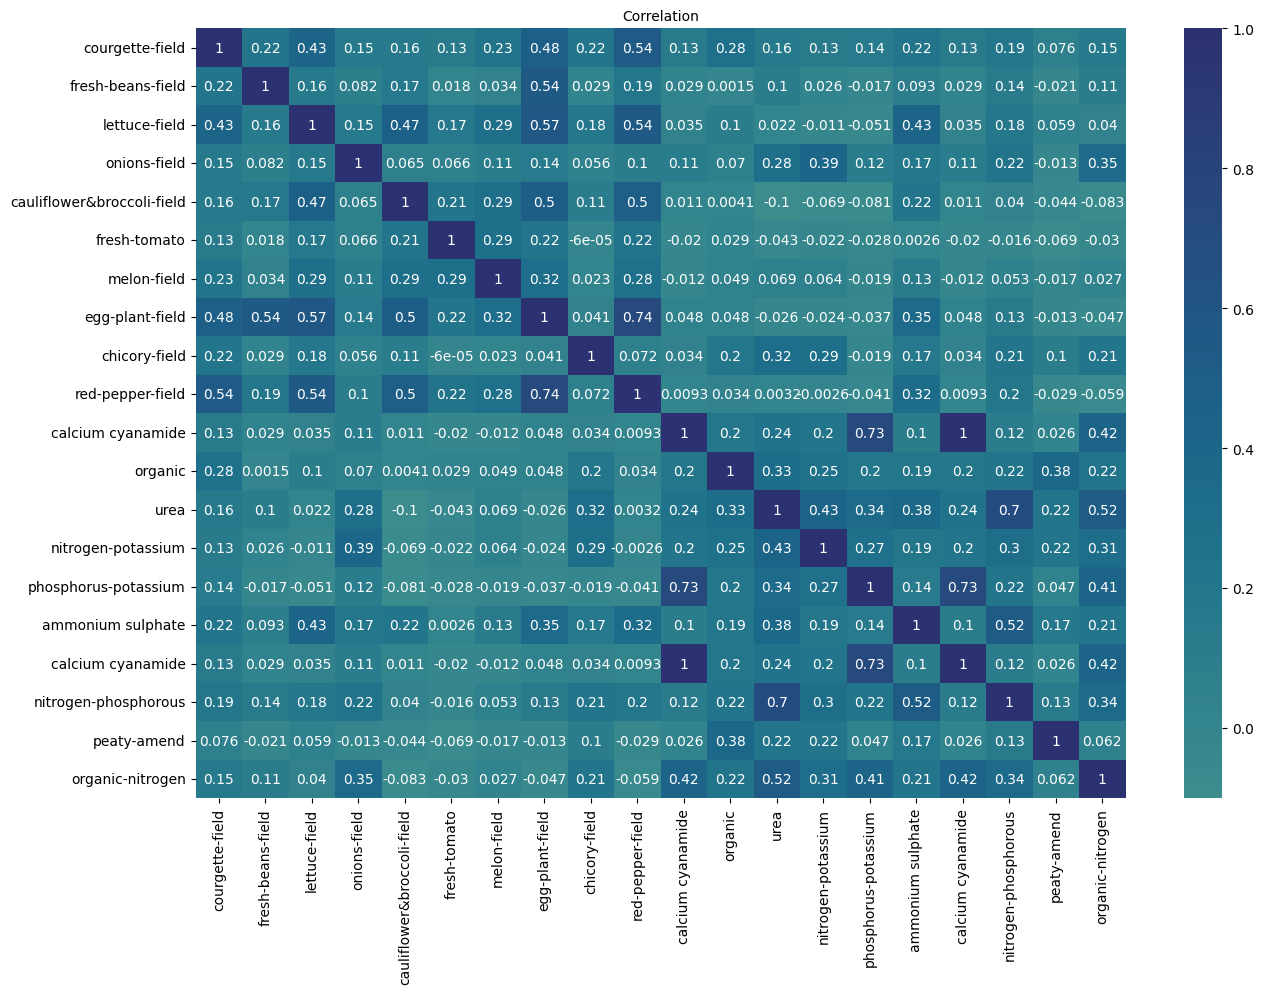

In [112]:
plt.figure(figsize=(15,10))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of fresh vegetables production in Italy    

* Cougette has high correlation with Red pepper, and correlation with Egg-plant Lettuce.

* Fresh beans has hight correlation with Egg-plant.

* Onions has low correlation with fertilizers and other crops.

* Melon has low correlation with fertilizers and other crops.

* Chicory has low correlation with fertilizers and other crops

* Urea has hight correlation with nitrogen-phosphorus, phosphorus-potassium with calcium cyanamide, and organic-nitrogen has hight correlation with phosphorus-potassium and urea. 

### Calculating Variance Inflation Factor (VIF) for all given features



In [106]:
# Function to compute the VIF
def compute_vif(selected_features):
    
    y = cor_selected [selected_features]
    # the calculation of variance inflation requires a constant
    y['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Feature"] = y.columns
    vif["VIF"] = [variance_inflation_factor(y.values, i) for i in range(y.shape[1])]
    vif = vif[vif['Feature']!='intercept']
    return vif

In [107]:
# Features selection
selected_features = ['courgette-field', 'fresh-beans-field',
                      'lettuce-field','onions-field','cauliflower&broccoli-field',
                      'fresh-tomato','melon-field','egg-plant-field',
                      'chicory-field','red-pepper-field', 
                       'calcium cyanamide','organic', 'urea','nitrogen-potassium',
                       'phosphorus-potassium','ammonium sulphate','calcium cyanamide', 
                       'nitrogen-phosphorous','peaty-amend','organic-nitrogen']

# compute vif 
compute_vif(selected_features).sort_values('VIF', ascending=False)


,Feature,VIF
11,calcium cyanamide,inf
18,calcium cyanamide,inf
17,calcium cyanamide,inf
10,calcium cyanamide,inf
7,egg-plant-field,4.563274
9,red-pepper-field,3.204208
13,urea,2.949030
15,phosphorus-potassium,2.508996
19,nitrogen-phosphorous,2.413793
2,lettuce-field,2.005061


The variable Calcium-cyanamide has showed in the Variance Inflation Factor (VIF) = inf (infinity), This result shows perfect correlation and multicollinearity, the causes of this result can vary therefore for the purpose of this work  the variable will not be used in the model. 

Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html


https://www.statisticshowto.com/variance-inflation-factor/

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/